<a href="https://colab.research.google.com/github/Danielbatista0590/earthengine-api/blob/master/NDVI_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pivot Irrigation NDVI Time Series Forecasting 

Packages Installation:

In [ ]:
!pip install ipygee
!pip install tslearn
!pip install earthengine-api
!pip install geopandas
!pip install pyramid-arima
!pip install fbprophet

     |████████████████████████████████| 5.1MB 19.4MB/s 
     |████████████████████████████████| 133kB 44.7MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
     |████████████████████████████████| 225kB 35.1MB/s 
  Created wheel for ipygee: filename=ipygee-0.0.14-cp36-none-any.whl size=39897 sha256=29882a4bf6b6da73026d58db89bf7c8327fab1133abbb9abaf7da1a332503014
  Stored in directory: /root/.cache/pip/wheels/57/f1/a2/ce9509a072ede592c0c9239ba66a1e9bb8af37bab3ca72fabc
  Created wheel for geetools: filename=geetools-0.6.0-cp36-none-any.whl size=81650 sha256=62b9d8ee4ccac3c4213ca295cde7000c2d947f492da1f4f8738967d5622a124b
  Stored in directory: /root/.cache/pip/wheels/8b/0d/90/c214fd045df9bfc0e9f15dd5819ad4038fc90fab431e77da72
  Created wheel for pyshp: filename=pyshp-2.1.2-cp36-none-any.whl size=36216 sha256=70f7607cc017d80eded8504d0be6b341dcecaed24048cd8cf52ab8236a73418b
  Stored in directory: /root/.cache/pip/wheels/96/6c/53/4112475adf3b831da97f083163d0f38ee6daac9c1b13f7afea
S

Google Earth Engine Authentication:

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=rHvBwD4qg6WDb69K8CYYZxUF5ln5M7TBSNw4W2ACXKE&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/4gGxS8bA9Th3mFgQQHLN-_yfX_z_01NeWoUXbL2qCD80ph03IK8ONLw

Successfully saved authorization token.


Importations:

In [ ]:
import folium
from folium import plugins
from IPython.display import Image
import geopandas as gpd
from ipygee import*
import pandas as pd

Define AOI: Nile Delta - Egypt

In [ ]:
AOI = ee.Geometry.Polygon(
                          [[[30.927817493633476, 30.975861359948926],
                            [30.927817493633476, 29.962686838962927],
                            [32.383505970195976, 29.962686838962927],
                            [32.383505970195976, 30.975861359948926]]])

Point of interest: Pivot Irrigation

In [ ]:
Point_1 = ee.FeatureCollection(
        [ee.Feature(
            ee.Geometry.Point([31.944300636088183, 30.441699038213567]),
            {
              "system:index": "0"
            })]);

Sentinel 2 actually image from AOI:

In [ ]:
startDateviz = ee.Date.fromYMD(2020,3,1);
endDateviz = ee.Date.fromYMD(2020,5,29);
collectionviz = ee.ImageCollection("COPERNICUS/S2").filterDate(startDateviz,endDateviz).filterBounds(AOI).filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 0.1);

In [ ]:
S2 = collectionviz.median().clip(AOI).divide(10000)
vis_params = {'min': 0, 'max': 0.4, 'bands': ['B4', 'B3','B2']}

In [ ]:
NDVI = S2.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndvi_params = {'min': 0, 'max': 0.8, 'palette': ['red', 'yellow','green']}

Folium Basemaps:

In [ ]:
basemaps = {
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    )}

In [ ]:
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

Create Folium Layout and add Layers:

In [ ]:
my_map = folium.Map(location=[30.448714, 31.983516], zoom_start=10)

# Add custom basemaps
basemaps['Google Terrain'].add_to(my_map)

# Add the elevation model to the map object.
my_map.add_ee_layer(S2, vis_params, 'Sentinel 2')
my_map.add_ee_layer(NDVI, ndvi_params, 'NDVI')
my_map.add_ee_layer(Point_1.geometry(), {}, 'Point 1')
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

## NDVI Prediction

Select Dates: 2016 to 2020

In [ ]:
startDate = ee.Date.fromYMD(2016,1,1);
endDate = ee.Date.fromYMD(2020,9,24);

Only Images with no clouds.

In [ ]:
S2_nocloud = ee.ImageCollection("COPERNICUS/S2").filterDate(startDate,endDate).filterBounds(AOI).filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 1)

Create NDVI to Collection:

In [ ]:
S2_NDVI_nocloud = S2_nocloud.map(lambda image: image.normalizedDifference(['B8', 'B4']).rename('NDVI').copyProperties(image, ['system:time_start']))

Create ipygee Time Sereis Chart:

In [ ]:
point_ndvi = chart.Image.series(**{'imageCollection': S2_NDVI_nocloud,
                                   'region': Point_1,
                                   'reducer': ee.Reducer.mean(),
                                   'bands' : 'NDVI',
                                   'scale': 20,
                                   'xProperty': 'system:time_start'})

In [ ]:
point_ndvi.renderWidget(width='50%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

Convert Chart to Pandas DataFrame

In [ ]:
p1_dataframe = point_ndvi.dataframe

In [ ]:
p1_dataframe.drop_duplicates(subset=None, keep='first', inplace=True)

In [ ]:
p1_dataframe

,NDVI
2016-01-10 08:50:36.287,0.373639
2016-02-19 08:40:13.000,0.600354
2016-03-10 08:41:11.503,0.675023
2016-04-19 08:39:54.923,0.190347
2016-04-29 08:34:28.000,0.158708
...,...
2020-08-26 08:41:57.765,0.086720
2020-08-31 08:41:55.641,0.080631
2020-09-05 08:41:56.835,0.091295
2020-09-15 08:41:56.746,0.080017


Plot chart using matplotlib and seaborn:

In [ ]:
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

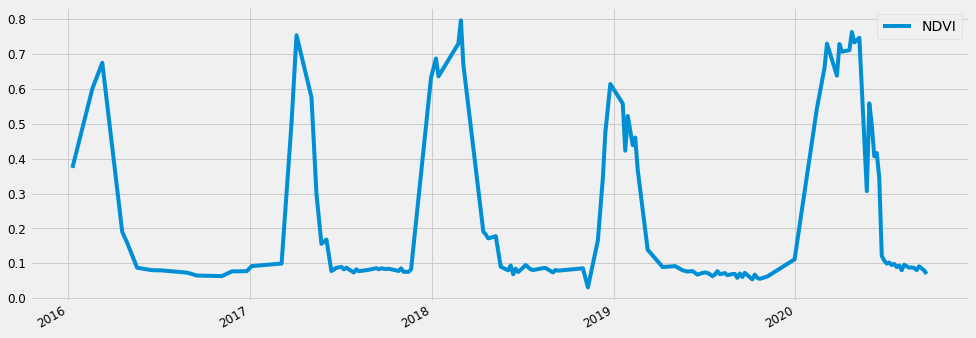

In [ ]:
p1_dataframe.plot(figsize=(15, 6))
plt.show()

In [ ]:
MA3 = p1_dataframe['NDVI'].rolling(window=3).mean()

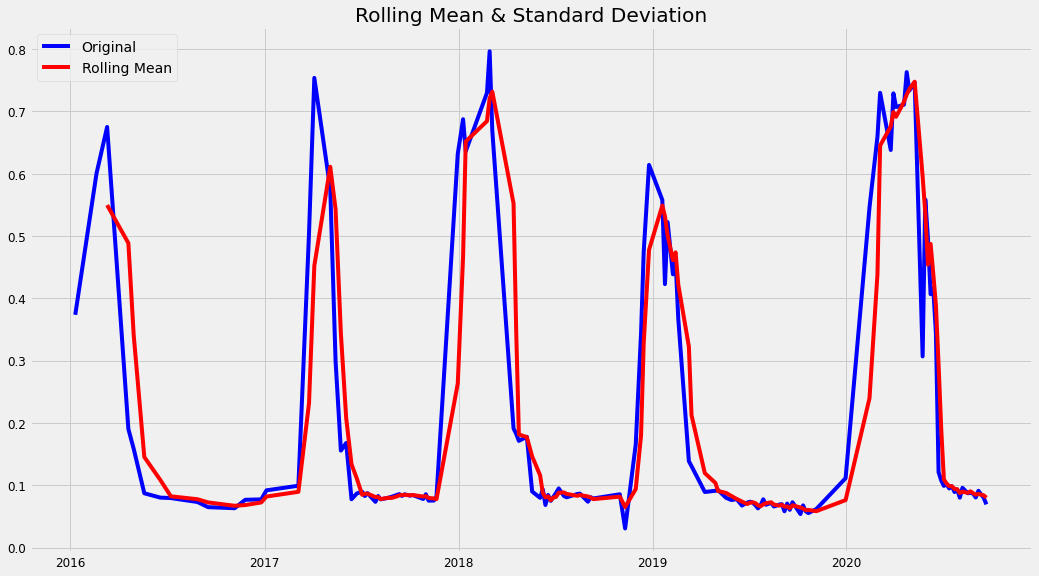

In [ ]:
orig = plt.plot(p1_dataframe, color='blue',label='Original')
mean = plt.plot(MA3, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# NDVI Time Series Analysis

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from random import random
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from pylab import rcParams
from pyramid.arima import auto_arima
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr

In [ ]:
p1_dataframe.reset_index(inplace=True)

In [ ]:
p1_dataframe['index'] = p1_dataframe['index'].dt.date

In [ ]:
p1_dataframe['index'] = pd.to_datetime(p1_dataframe['index'], format='%Y-%m')

In [ ]:
p1_dataframe = p1_dataframe.set_index('index')

In [ ]:
p1_dataframe

,NDVI
index,
2016-01-10,0.373639
2016-02-19,0.600354
2016-03-10,0.675023
2016-04-19,0.190347
2016-04-29,0.158708
...,...
2020-08-26,0.086720
2020-08-31,0.080631
2020-09-05,0.091295


## **Seasonal Decomposition**

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

Level: The average value in the series.

Trend: The increasing or decreasing value in the series.

Seasonality: The repeating short-term cycle in the series.

Residual: The random variation in the series.

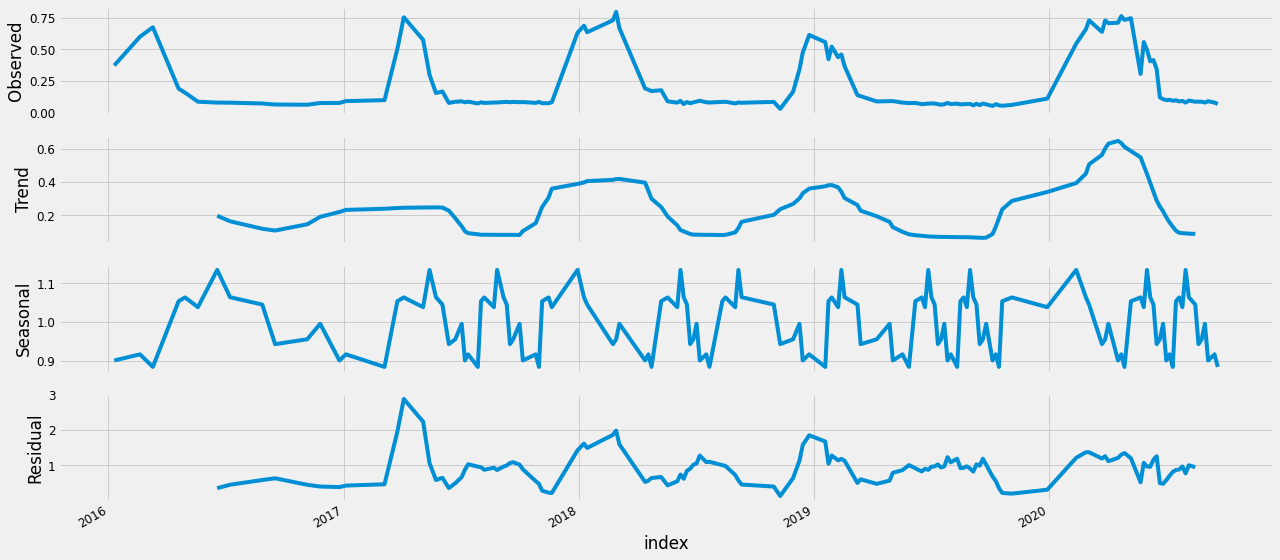

In [ ]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(p1_dataframe, model='multiplicative',freq=12)
fig = decomposition.plot()
plt.show()

Divide Data in Train and Valid

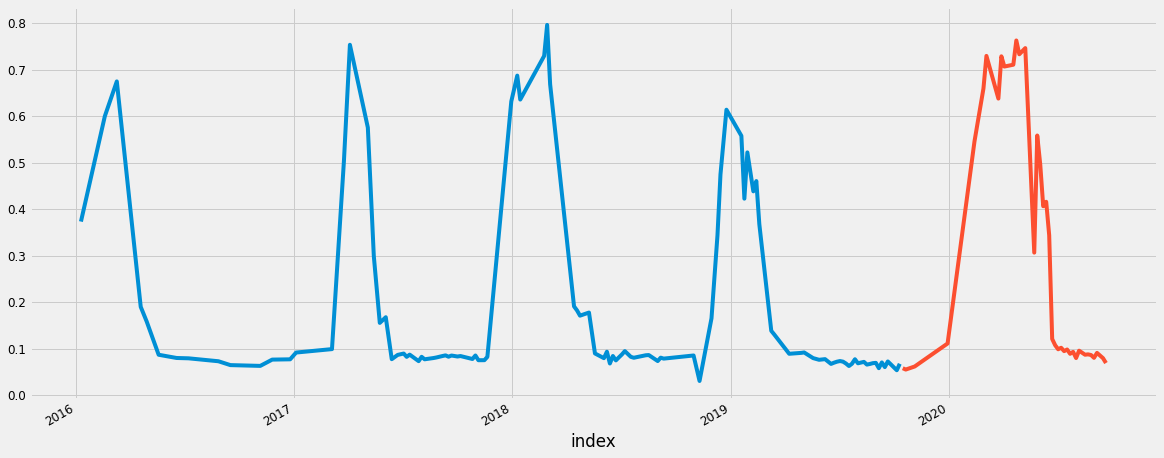

In [ ]:
train = p1_dataframe[:int(0.75*(len(p1_dataframe)))]
valid = p1_dataframe[int(0.75*(len(p1_dataframe))):]

#plotting the data
train['NDVI'].plot()
valid['NDVI'].plot()

# **Autoregression (AR)**

The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.

The notation for the model involves specifying the order of the model p as a parameter to the AR function, e.g. AR(p). For example, AR(1) is a first-order autoregression model.

The method is suitable for univariate time series without trend and seasonal components.

In [ ]:
model_AR = AR(train)
model_fit_AR = model_AR.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


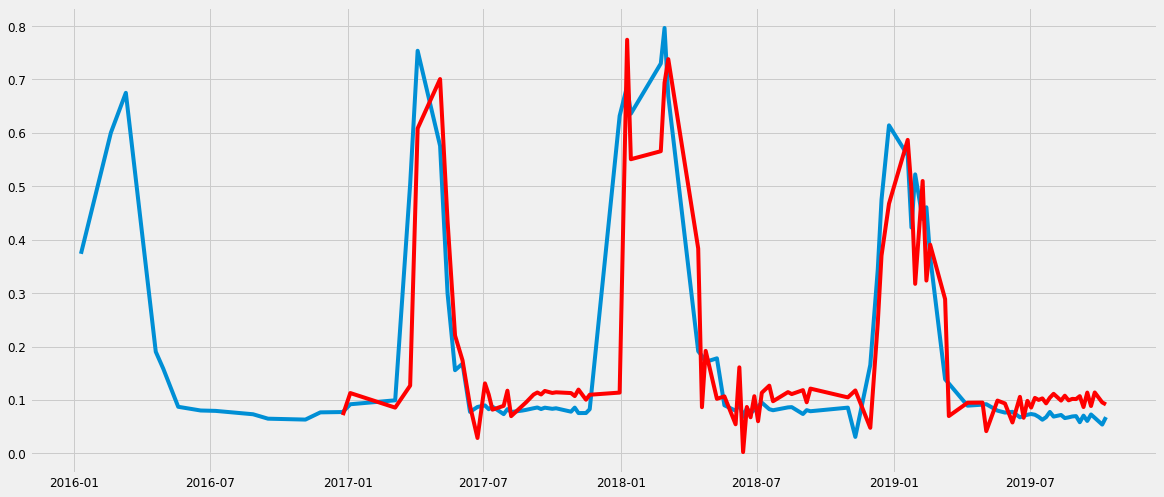

In [ ]:
plt.plot(train)
plt.plot(model_fit_AR.fittedvalues, color='red')
plt.show()

In [ ]:
predictions_AR = model_fit_AR.predict(
    start=len(train), 
    end=len(train) + len(valid)-1, 
    dynamic=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


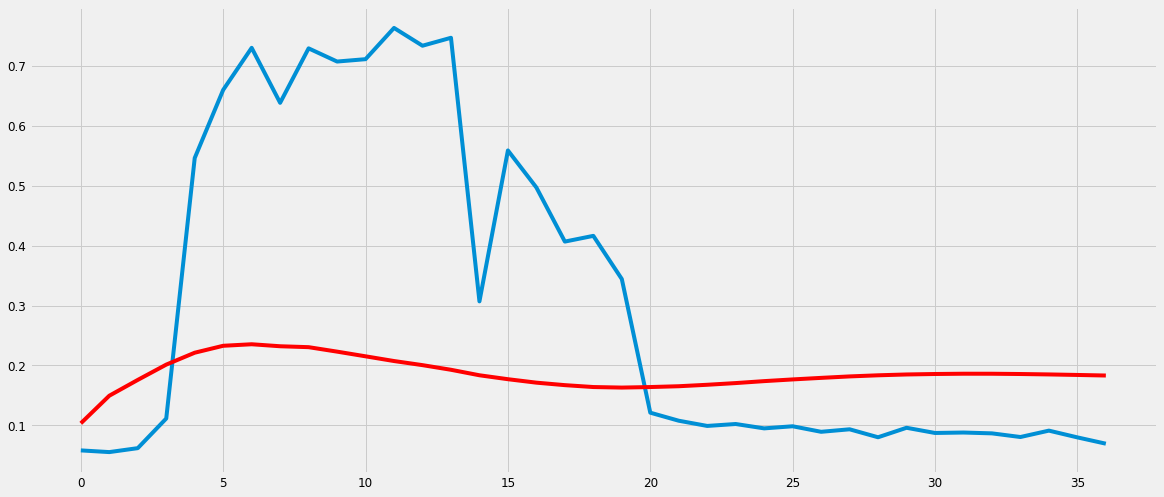

In [ ]:
plt.plot(valid.values)
plt.plot(predictions_AR.values, color='red')
plt.show()

In [ ]:
print('R2_score:' ,r2_score(valid.values, predictions_AR.values))
print('MAE:', mean_absolute_error(valid.values, predictions_AR.values))
print('MSE:', mean_squared_error(valid.values, predictions_AR.values))
print('RMSE:',mean_squared_error(valid.values, predictions_AR.values, squared=False))

R2_score: -0.08348491520498746
MAE: 0.21879814840826883
MSE: 0.07867653380771653
RMSE: 0.28049337569311067


# Moving Average (MA)

The moving average (MA) method models the next step in the sequence as a linear function of the residual errors from a mean process at prior time steps.

A moving average model is different from calculating the moving average of the time series.

The notation for the model involves specifying the order of the model q as a parameter to the MA function, e.g. MA(q). For example, MA(1) is a first-order moving average model.

The method is suitable for univariate time series without trend and seasonal components.

In [ ]:
model_MA = ARMA(train, order=(0, 1))
model_fit_MA = model_MA.fit(disp=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
model_fit_MA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   NDVI   No. Observations:                  110
Model:                     ARMA(0, 1)   Log Likelihood                  70.970
Method:                       css-mle   S.D. of innovations              0.126
Date:                Wed, 30 Sep 2020   AIC                           -135.940
Time:                        19:47:54   BIC                           -127.839
Sample:                             0   HQIC                          -132.654
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1824      0.023      8.030      0.000       0.138       0.227
ma.L1.NDVI     0.8991      0.048     18.899      0.000       0.806       0.992
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.1122           +0.0000j            1.1122            0.5000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.0000')

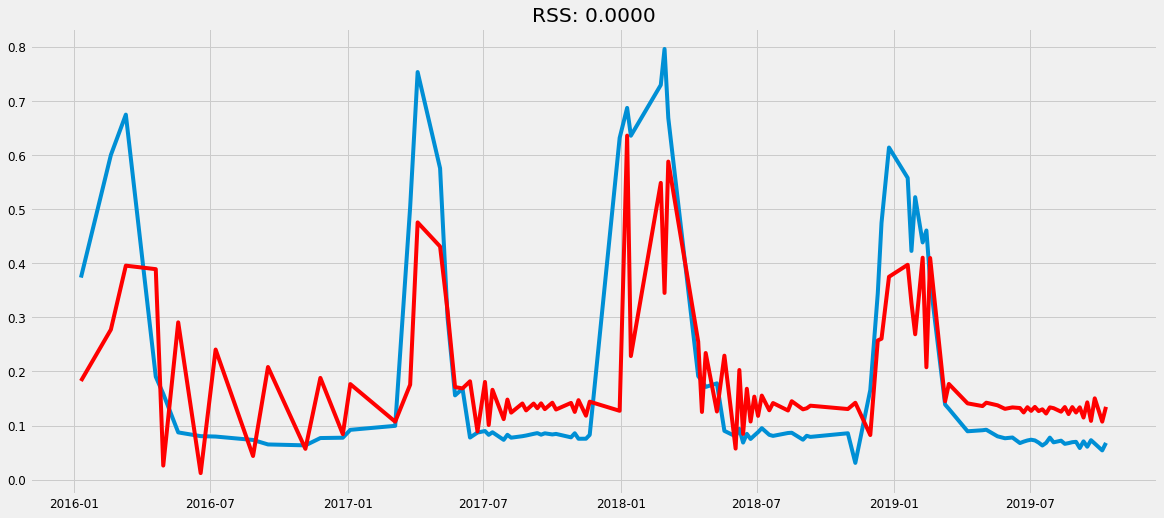

In [ ]:
plt.plot(train)
plt.plot(model_fit_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit_MA.fittedvalues-train)**2))

In [ ]:
predictions_MA = model_fit_MA.predict(
    start=len(train), 
    end=len(train) + len(valid)-1, 
    dynamic=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


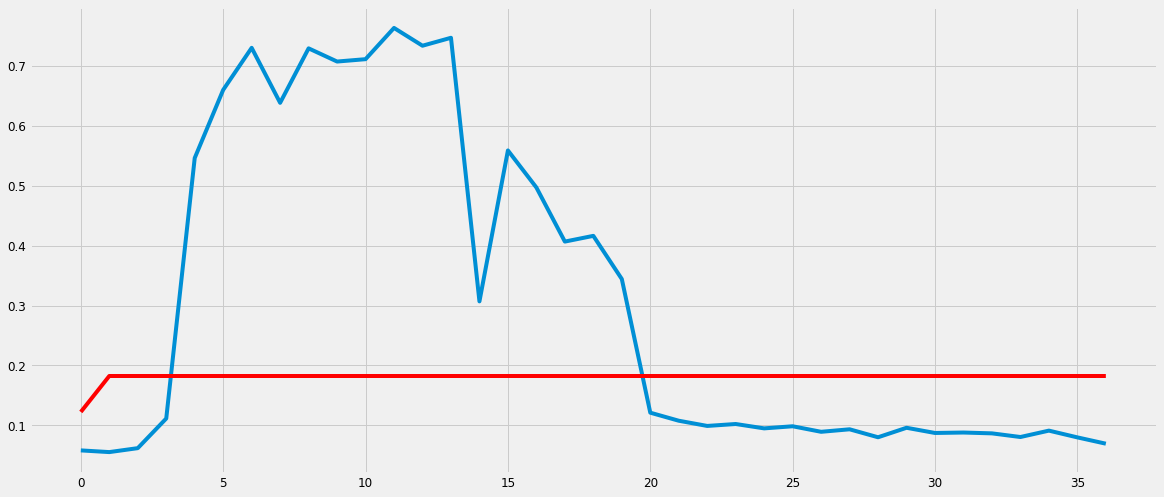

In [ ]:
plt.plot(valid.values)
plt.plot(predictions_MA.values, color='red')
plt.show()

In [ ]:
print('R2_score:' ,r2_score(valid.values, predictions_MA.values))
print('MAE:', mean_absolute_error(valid.values, predictions_MA.values))
print('MSE:', mean_squared_error(valid.values, predictions_MA.values))
print('RMSE:',mean_squared_error(valid.values, predictions_MA.values, squared=False))

R2_score: -0.20843014283946815
MAE: 0.22947217510882192
MSE: 0.08774934810180131
RMSE: 0.29622516453164693


# **Autoregressive Moving Average (ARMA)**

The Autoregressive Moving Average (ARMA) method models the next step in the sequence as a linear function of the observations and resiudal errors at prior time steps.

It combines both Autoregression (AR) and Moving Average (MA) models.

The notation for the model involves specifying the order for the AR(p) and MA(q) models as parameters to an ARMA function, e.g. ARMA(p, q). An ARIMA model can be used to develop AR or MA models.

The method is suitable for univariate time series without trend and seasonal components.

In [ ]:
model_ARMA = ARMA(train, order=(2, 1))
model_fit_ARMA = model_ARMA.fit(disp=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 0.0000')

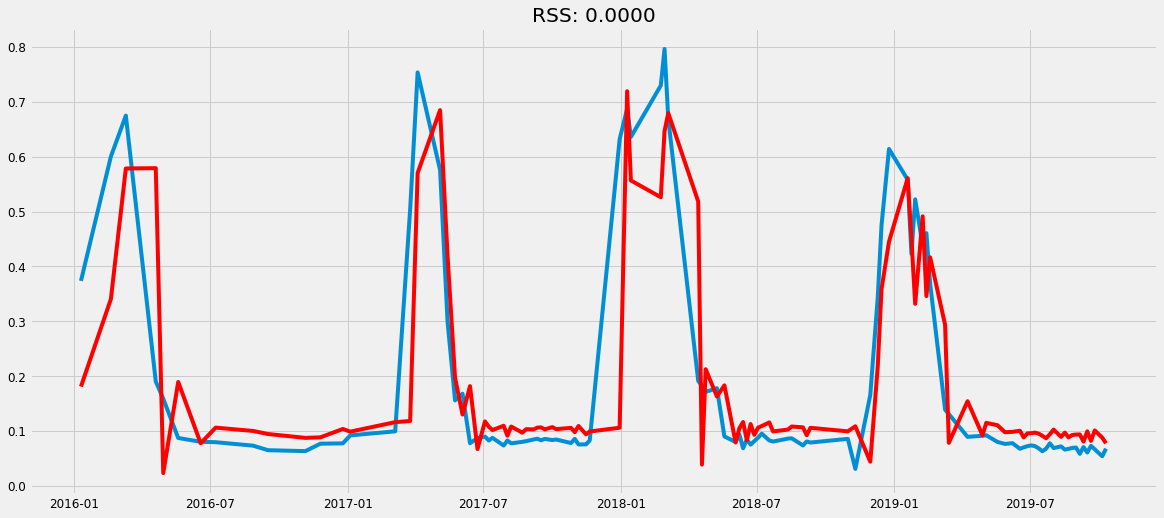

In [ ]:
plt.plot(train)
plt.plot(model_fit_ARMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit_ARMA.fittedvalues-train)**2))

In [ ]:
predictions_ARMA = model_fit_ARMA.predict(
    start=len(train), 
    end=len(train) + len(valid)-1, 
    dynamic=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


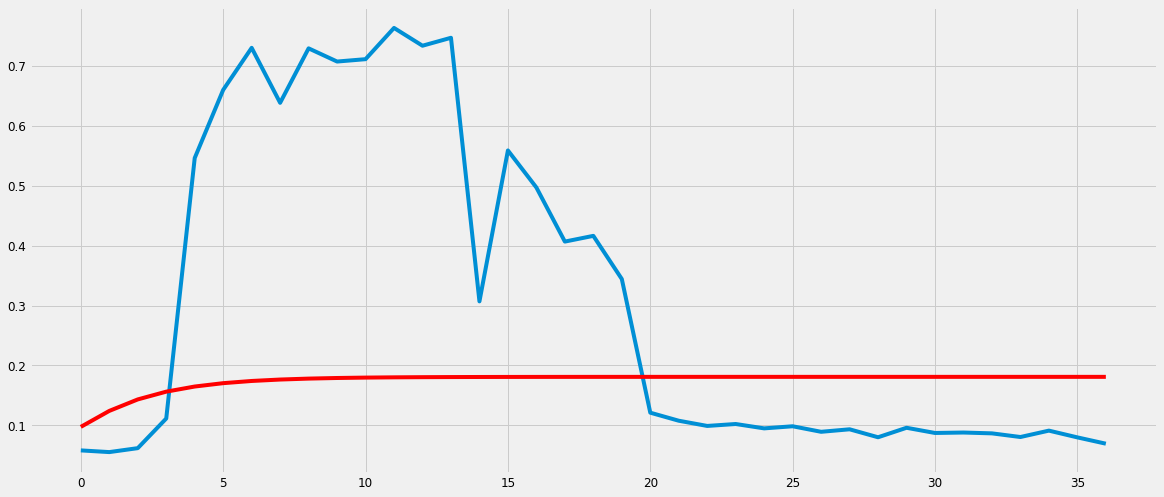

In [ ]:
plt.plot(valid.values)
plt.plot(predictions_ARMA.values, color='red')
plt.show()

In [ ]:
print('R2_score:' ,r2_score(valid.values, predictions_ARMA.values))
print('MAE:', mean_absolute_error(valid.values, predictions_ARMA.values))
print('MSE:', mean_squared_error(valid.values, predictions_ARMA.values))
print('RMSE:',mean_squared_error(valid.values, predictions_ARMA.values, squared=False))

R2_score: -0.22041481987211187
MAE: 0.22667810259053497
MSE: 0.08861960742382886
RMSE: 0.2976904557150411


# Autoregressive Integrated Moving Average (ARIMA)

The Autoregressive Integrated Moving Average (ARIMA) method models the next step in the sequence as a linear function of the differenced observations and residual errors at prior time steps.

It combines both Autoregression (AR) and Moving Average (MA) models as well as a differencing pre-processing step of the sequence to make the sequence stationary, called integration (I).

The notation for the model involves specifying the order for the AR(p), I(d), and MA(q) models as parameters to an ARIMA function, e.g. ARIMA(p, d, q). An ARIMA model can also be used to develop AR, MA, and ARMA models.

The method is suitable for univariate time series with trend and without seasonal components

In [ ]:
model_ARIMA = ARIMA(train, order=(1, 1, 1))
model_fit_ARIMA = model_ARIMA.fit(disp=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 0.0000')

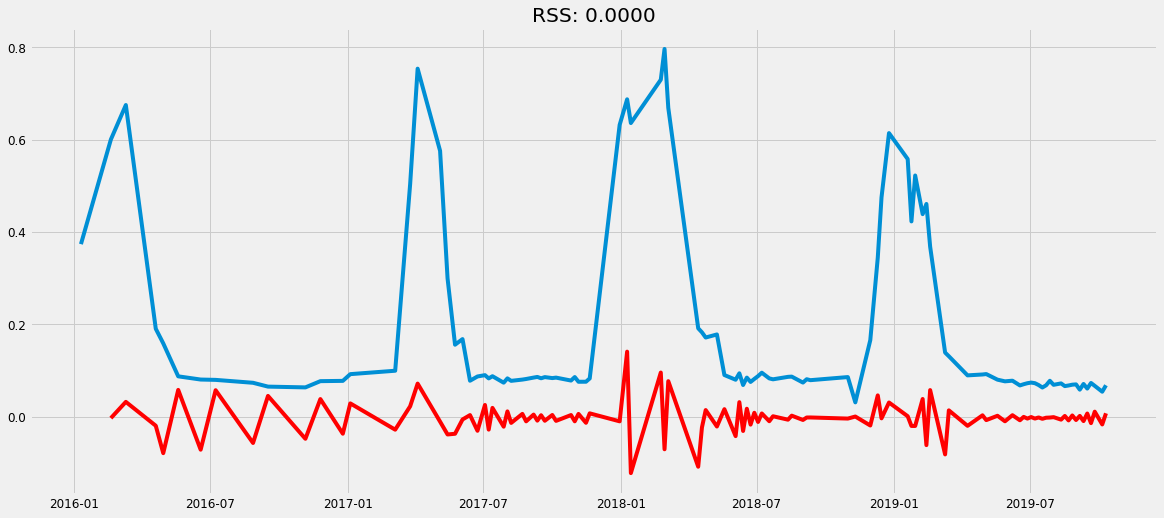

In [ ]:
plt.plot(train)
plt.plot(model_fit_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit_ARIMA.fittedvalues-train)**2))

In [ ]:
predictions_ARIMA = model_fit_ARIMA.predict(start=len(train), 
    end=len(train) + len(valid)-1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


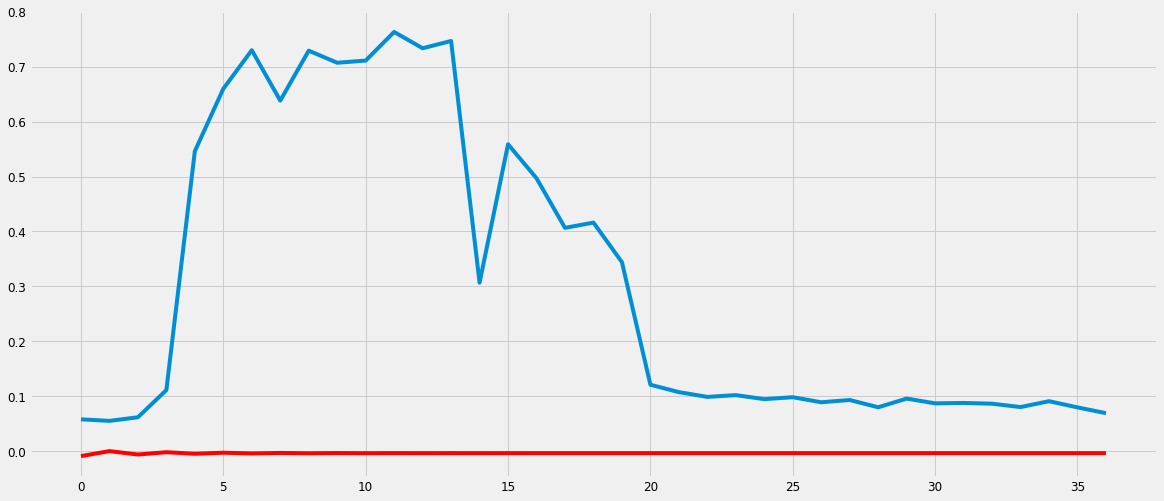

In [ ]:
plt.plot(valid.values)
plt.plot(predictions_ARIMA.values, color='red')
plt.show()

In [ ]:
model_A_A = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=6, stepwise=True)
model_A_A.fit(train)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 6); AIC=-183.099, BIC=-161.495, Fit time=0.903 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 6); AIC=-40.943, BIC=-35.542, Fit time=0.042 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 6); AIC=-171.054, BIC=-160.253, Fit time=0.200 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 6); AIC=-136.503, BIC=-125.701, Fit time=0.254 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 1, 6); AIC=-182.679, BIC=-163.776, Fit time=0.578 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 1, 6); AIC=-181.827, BIC=-157.523, Fit time=1.544 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 0, 6); AIC=-177.565, BIC=-158.661, Fit time=0.742 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 2, 6); AIC=-181.796, BIC=-157.492, Fit time=1.624 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 6); AIC=-176.992, BIC=-160.789, Fit time=0.440 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_ord

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 0, 1),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(1, 0, 1, 6), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend='c')

In [ ]:
pred_A_A = model_A_A.predict(n_periods=len(valid))

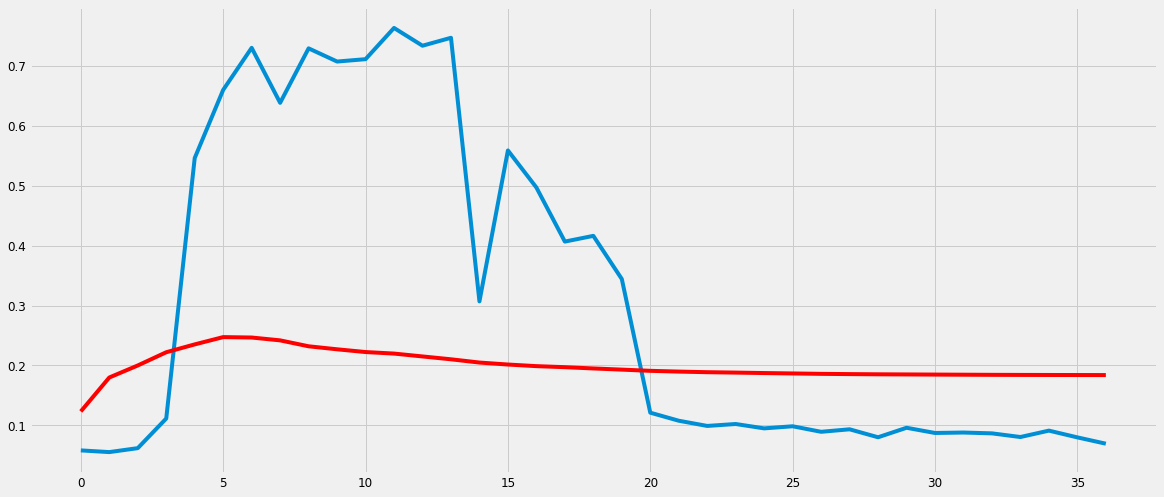

In [ ]:
plt.plot(valid.values)
plt.plot(pred_A_A, color='red')
plt.show()

In [ ]:
print('R2_score:' ,r2_score(valid.values, pred_A_A))
print('MAE:', mean_absolute_error(valid.values, pred_A_A))
print('MSE:', mean_squared_error(valid.values, pred_A_A))
print('RMSE:',mean_squared_error(valid.values, pred_A_A, squared=False))

R2_score: -0.030784290944139592
MAE: 0.21728136065724088
MSE: 0.07484971315875354
RMSE: 0.2735867561830315


# Seasonal Autoregressive Integrated Moving-Average (SARIMA)

The Seasonal Autoregressive Integrated Moving Average (SARIMA) method models the next step in the sequence as a linear function of the differenced observations, errors, differenced seasonal observations, and seasonal errors at prior time steps.

It combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level.

The notation for the model involves specifying the order for the AR(p), I(d), and MA(q) models as parameters to an ARIMA function and AR(P), I(D), MA(Q) and m parameters at the seasonal level, e.g. SARIMA(p, d, q)(P, D, Q)m where “m” is the number of time steps in each season (the seasonal period). A SARIMA model can be used to develop AR, MA, ARMA and ARIMA models.

The method is suitable for univariate time series with trend and/or seasonal components.

In [ ]:
model_SARIMAX = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
model_fit_SARIMAX = model_SARIMAX.fit(disp=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 0.0000')

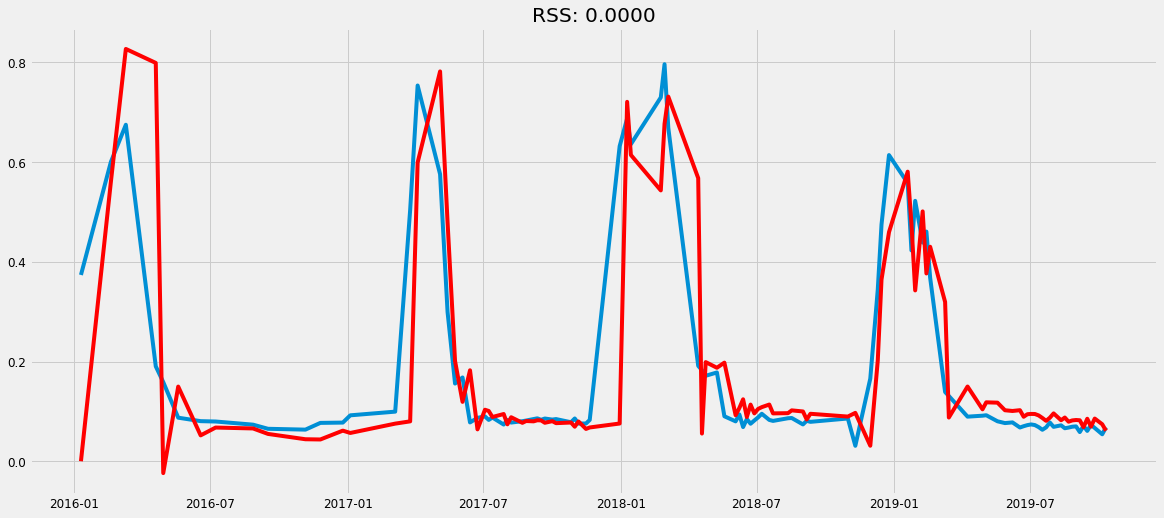

In [ ]:
plt.plot(train)
plt.plot(model_fit_SARIMAX.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit_SARIMAX.fittedvalues-train)**2))

In [ ]:
predictions_SARIMAX = model_fit_SARIMAX.predict(start=len(train), 
    end=len(train) + len(valid)-1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


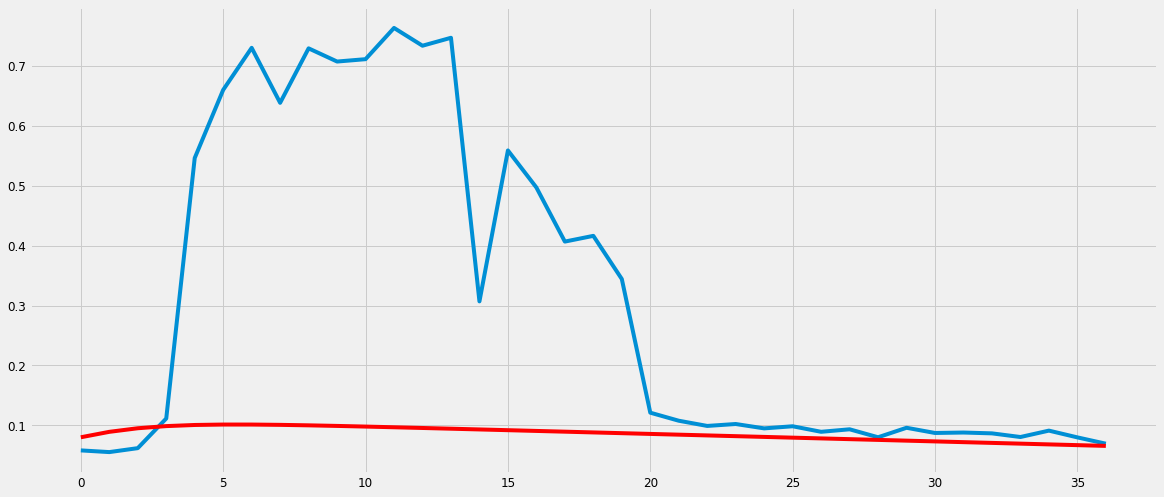

In [ ]:
plt.plot(valid.values)
plt.plot(predictions_SARIMAX.values, color='red')
plt.show()

In [ ]:
print('R2_score:' ,r2_score(valid.values, predictions_SARIMAX.values))
print('MAE:', mean_absolute_error(valid.values, predictions_SARIMAX.values))
print('MSE:', mean_squared_error(valid.values, predictions_SARIMAX.values))
print('RMSE:',mean_squared_error(valid.values, predictions_SARIMAX.values, squared=False))

R2_score: -0.6078879647112232
MAE: 0.22546700407931278
MSE: 0.1167557111680596
RMSE: 0.34169534847296296


# Prophet

Prophet is a procedure for forecasting time series data based on an additive/multiplicative model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

It works best with time series that have strong seasonal effects and several seasons of historical data.

Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

The Prophet package provides intuitive parameters which are easy to tune.

Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [ ]:
from fbprophet import Prophet

In [ ]:
train_prophet = pd.DataFrame()
train_prophet['ds'] = train.index
train_prophet['y'] = train.NDVI.values

valid_prophet = pd.DataFrame()
valid_prophet['ds'] = valid.index
valid_prophet['y'] = valid.NDVI.values

In [ ]:
model_Prophet=Prophet(interval_width=0.95, daily_seasonality=False, changepoint_range=0.7, changepoint_prior_scale=0.3)   
model_Prophet.fit(train_prophet)

In [ ]:
forecast_d =(valid.index[-1]-valid.index[0]).days

In [ ]:
forecast_d

340

In [ ]:
future = model_Prophet.make_future_dataframe(periods = forecast_d, freq = 'D')

In [ ]:
predictions = model_Prophet.predict(future)

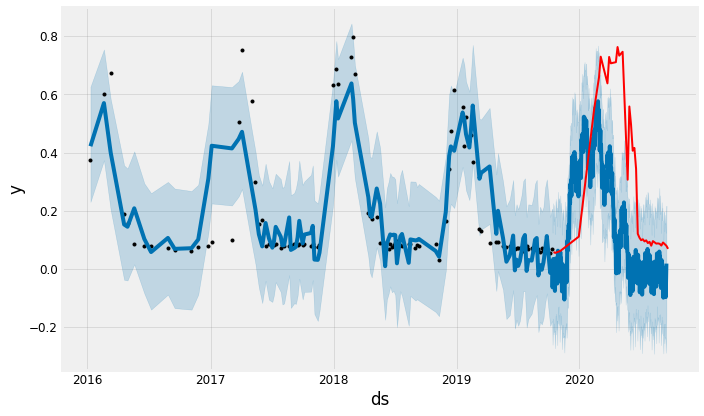

In [ ]:
fig = model_Prophet.plot(predictions)
plt.plot(valid, label='Valid', color = 'red', linewidth = 2)
plt.show()

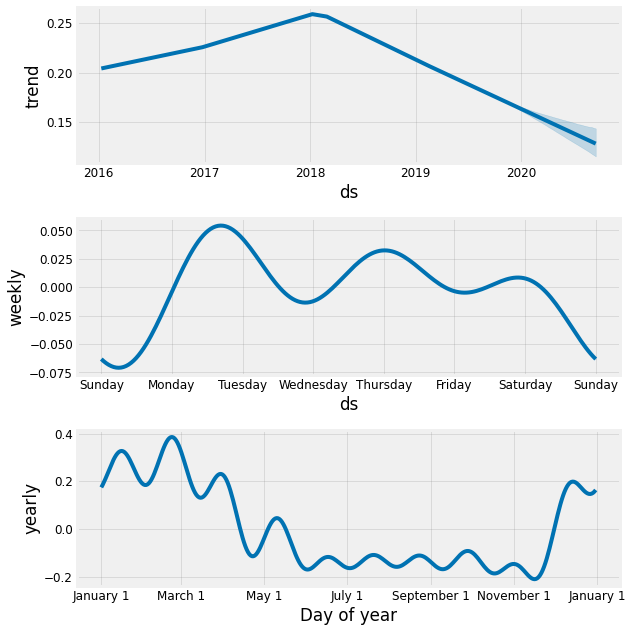

In [ ]:
model_Prophet.plot_components(predictions);

In [ ]:
pred = predictions[predictions.ds.isin(valid.index)]

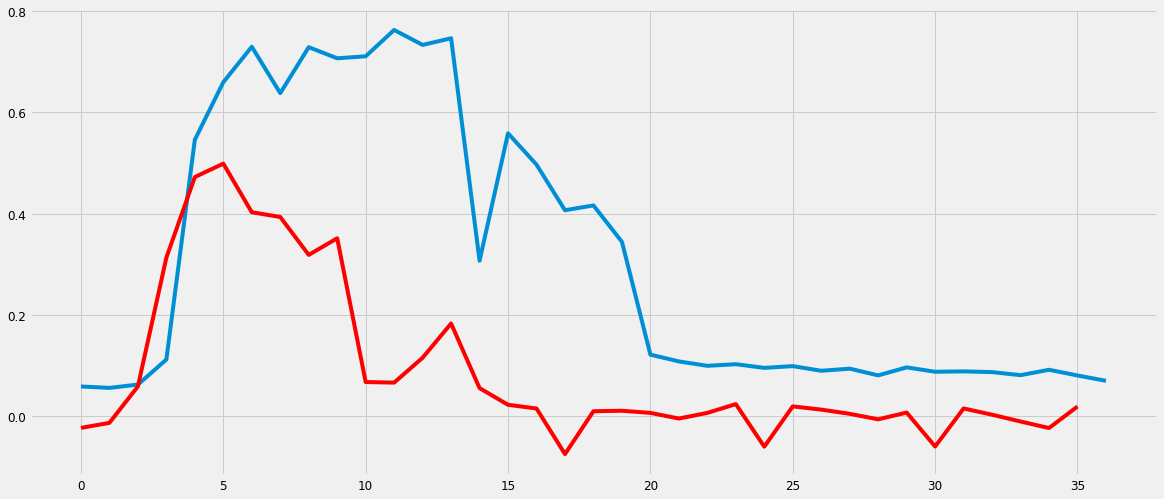

In [ ]:
plt.plot(valid.values)
plt.plot(pred.yhat.values, color='red')
plt.show()

In [ ]:
print('R2_score:' ,r2_score(valid[:-1].values, pred.yhat.values))
print('MAE:', mean_absolute_error(valid[:-1].values, pred.yhat.values))
print('MSE:', mean_squared_error(valid[:-1].values, pred.yhat.values))
print('RMSE:',mean_squared_error(valid[:-1].values, pred.yhat.values, squared=False))

R2_score: -0.2930537356837517
MAE: 0.23598161866269177
MSE: 0.09442578618352168
RMSE: 0.30728779048885374
